In [1]:
import math
import torch
import matplotlib.pyplot as plt
import pdb
import pandas as pd  
import seaborn as sns 
import numpy as np

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


dataset torch.Size([3, 2])


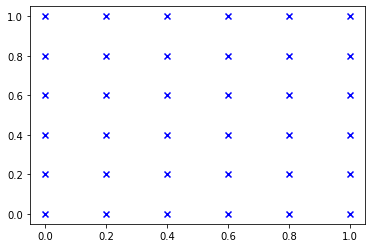

In [63]:
# from https://kornia.readthedocs.io/en/latest/_modules/kornia/utils/grid.html
from typing import Optional

def create_meshgrid(
        height: int,
        width: int,
        normalized_coordinates: Optional[bool] = True,
        device: Optional[torch.device] = torch.device('cpu')) -> torch.Tensor:
    """Generates a coordinate grid for an image.

    When the flag `normalized_coordinates` is set to True, the grid is
    normalized to be in the range [-1,1] to be consistent with the pytorch
    function grid_sample.
    http://pytorch.org/docs/master/nn.html#torch.nn.functional.grid_sample

    Args:
        height (int): the image height (rows).
        width (int): the image width (cols).
        normalized_coordinates (Optional[bool]): whether to normalize
          coordinates in the range [-1, 1] in order to be consistent with the
          PyTorch function grid_sample.

    Return:
        torch.Tensor: returns a grid tensor with shape :math:`(1, H, W, 2)`.
    """
    # generate coordinates
    xs: Optional[torch.Tensor] = None
    ys: Optional[torch.Tensor] = None
    if normalized_coordinates:
        xs = torch.linspace(-1, 1, width, device=device, dtype=torch.float)
        ys = torch.linspace(-1, 1, height, device=device, dtype=torch.float)
    else:
        xs = torch.linspace(0, width - 1, width, device=device, dtype=torch.float)
        ys = torch.linspace(0, height - 1, height, device=device, dtype=torch.float)
    # generate grid by stacking coordinates
    base_grid: torch.Tensor = torch.stack(
        torch.meshgrid([xs, ys])).transpose(1, 2)  # 2xHxW
    return torch.unsqueeze(base_grid, dim=0).permute(0, 2, 3, 1)  # 1xHxWx2

dataset = [[0.25, 0.25], [0.75, 0.75], [0.3, 0.3]]
dataset = torch.tensor(dataset).float()
print("dataset", dataset.shape)

grid_size = 6
patterns = create_meshgrid(grid_size, grid_size, normalized_coordinates=False).reshape(-1, 2) / (grid_size-1)
# patterns
plt.scatter(patterns[:, 0], patterns[:, 1], marker='x', c='b')
original_patterns = patterns.clone()

In [0]:
def similarity(x, patterns, subset_threshold=0.2):
  # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
  # print("x", x)
  dist = (x - patterns) ** 2
  # print("patterns", patterns)
  # print("dist", dist)
  dist = dist.sum(dim=-1) # TODO: use subset activation # TODO: apply mask (inverse variance)
  winner_index = dist.min(dim=0)[1]
  # print("winner_index", winner_index)

  winning_pattern = patterns[winner_index]
  a = 0.2 * ((x - winning_pattern) ** -2).mean(dim=-1)
  a[a > 5000.0] = 5000.0
  # print("a", a)
  s = 0.8
  sim = -a * (((x - patterns) ** 2).mean(dim=-1))
  # print("sim", sim)
  sim = (torch.exp(sim) - s * torch.exp(sim * 0.8)) / ((1 - s) * 0.685)
  sim[sim>1.0] = 1.0

  # print("sim", sim)

  return sim

sim = similarity(dataset[0], patterns)

Iteration  0


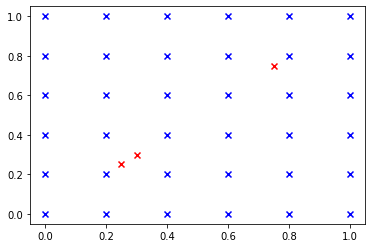

Iteration  1


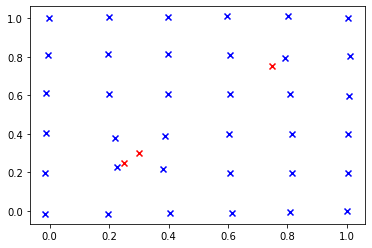

Iteration  2


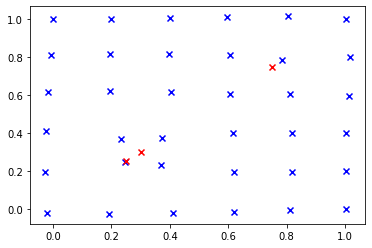

Iteration  3


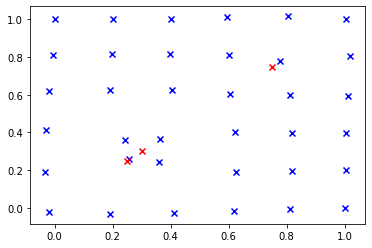

Iteration  4


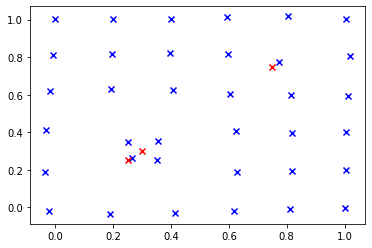

Iteration  5


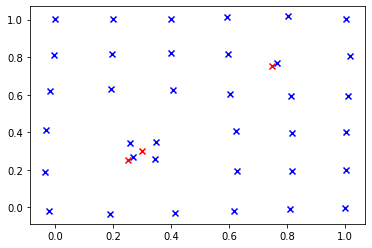

Iteration  6


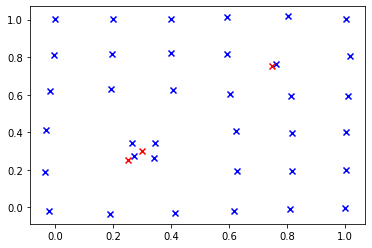

Iteration  7


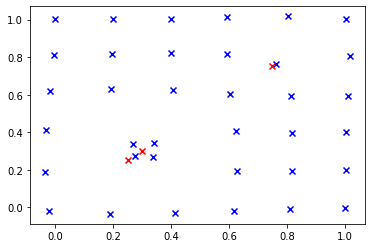

Iteration  8


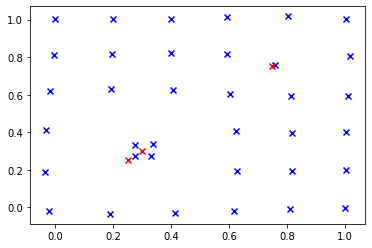

Iteration  9


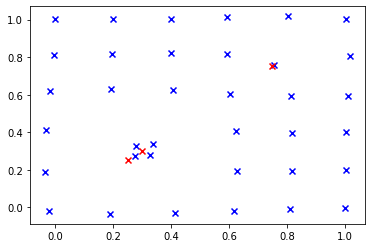

Iteration  10


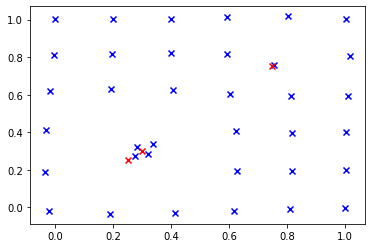

Iteration  11


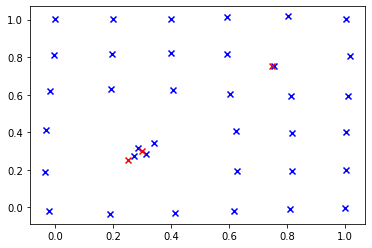

Iteration  12


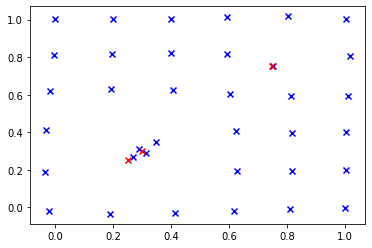

Iteration  13


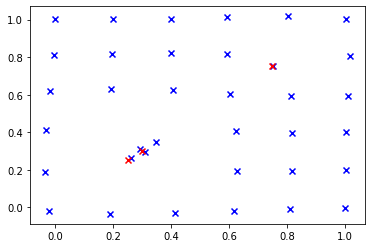

Iteration  14


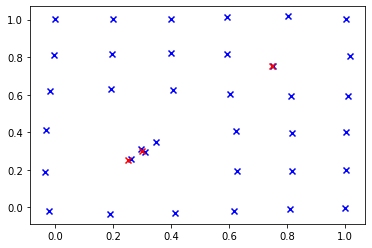

Iteration  15


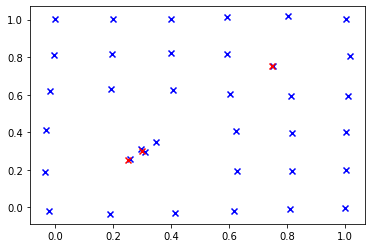

Iteration  16


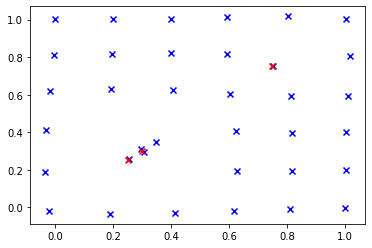

Iteration  17


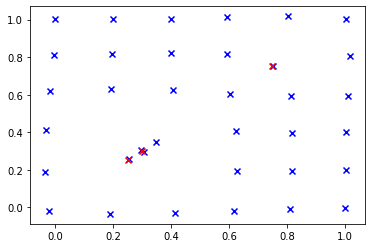

Iteration  18


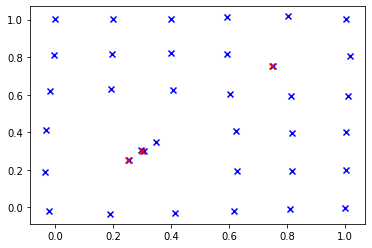

Iteration  19


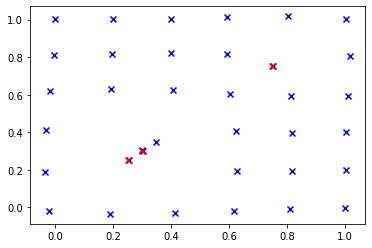

In [68]:
patterns = original_patterns
def plot_patterns(patterns, dataset):
  plt.scatter(patterns[:, 0], patterns[:, 1], marker='x', c='b')
  plt.scatter(dataset[:, 0], dataset[:, 1], marker='x', c='r')
  plt.show()

lr = 0.2
for i in range(20):
  print("Iteration ", i)
  plot_patterns(patterns, dataset)
  for x in dataset:
    sim = similarity(x, patterns).unsqueeze(-1)
    # print("(x - patterns)", (x - patterns).shape)
    # print("sim", sim.shape)
    delta = (x - patterns) * sim * lr
    patterns = patterns + delta

Notice 2D space clearing and datapoints acting as target patterns.

Notice the two dataset points in the lower left quadrant. At iteration 7, an average pattern emerges that is between the two datapoints. By iteration 12, the upper among the two datapoints gets its own dedicated patterns and the average pattern is released and becomes tuned to the lower datapoint by iteration 19. This might have cognitive implications.